# Pricing equity options
In this notebook I price American equity options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org) and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

## Constructing a riskless yield curve for USD
The first thing we need to do to price any option on a US equity is construct the so-called riskless yield curve for USD. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I use the Fed Funds effective rate and US Treasury Yields as proxies for riskless rates. Ideally, using OIS swap rates might be better as treasury yields tend to be slightly lower given the preferred tax treatment of treasuries. However US Treasury Rates are available for free from [FRED](https://fred.stlouisfed.org) with daily frequency while OIS swap rates not, and the difference is pretty small.

I use the following dataseries from FRED to accomplish the task:
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS1MO &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3MO &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS6MO &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS1 &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS2 &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3 &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS5 &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS7 &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS10 &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS20 &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS30 &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
import locale
from datetime import date, datetime

from dateutil.relativedelta import relativedelta
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import numpy as np
import pandas as pd

from volatility import parameter_estimators, volatility_trackers
from pricing import curves, options

_ = locale.setlocale(locale.LC_ALL, '')

In [2]:
today = date.today()

# Offsetting to the last business day if today is not a business day
today = today if len(pd.bdate_range(today, today)) else today - BDay(1)

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - BDay(2), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion to APY: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=2)

### Optional: Visualizing the riskless yield curve for USD

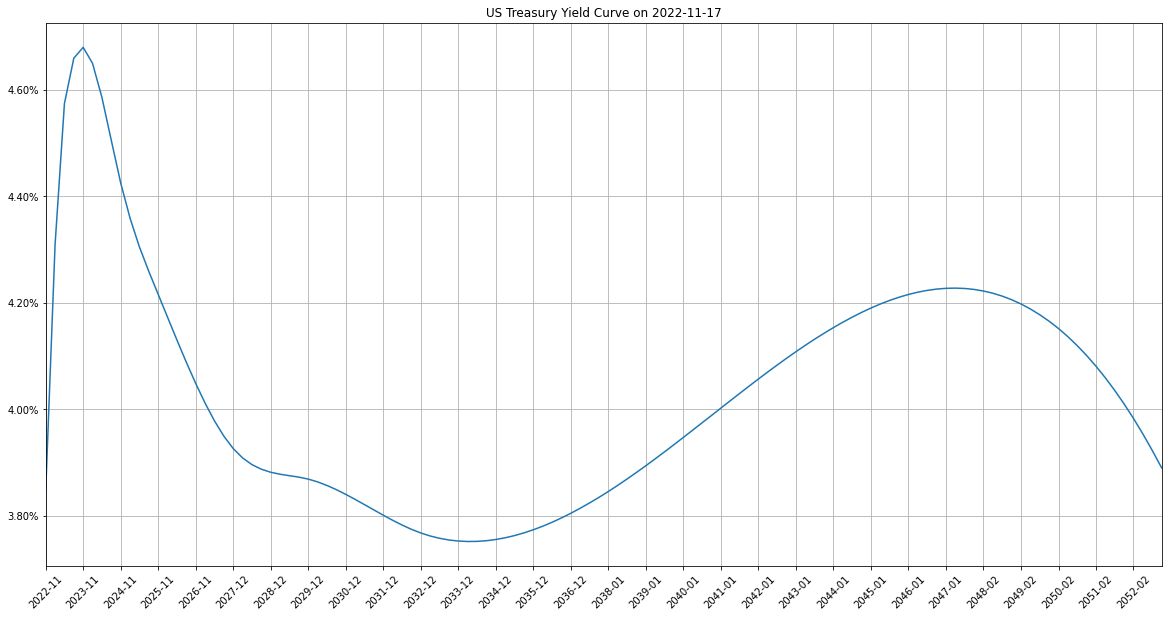

In [3]:
import matplotlib.ticker as mtick
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

## Estimating and forecasting volatility of the stock, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the stock whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for Apple

In [4]:
TICKER = 'AAPL'

# I'll use price changes since 1st Jan 2018 to estimate GARCH(1, 1) ω, α, and β parameters
start = date(2018, 1, 1)
data = web.get_data_yahoo(TICKER, start, today)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

Objective function: 8494.64879 after 97 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000020926303, α=0.12260, β=0.83234


##### Optional: Estimating with a faster estimator &mdash; GARCHVarianceTargetingParameterEstimator

In [5]:
var_target_vol_estimator = parameter_estimators.GARCHVarianceTargetingParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (var_target_vol_estimator.omega, var_target_vol_estimator.alpha, var_target_vol_estimator.beta))

Objective function: 8494.58896 after 29 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000021050807, α=0.11988, β=0.83282


#### Forecasting volatility for Apple
Now that we have obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast the volatility of AAPL stock. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [6]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for January 20th options
maturity_date = date(2023, month=1, day=20)
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of AAPL for term 0.1726 years: 0.37209


#### Optional: Visualizing historical and future volatility of Apple stock for 200 business days into the future

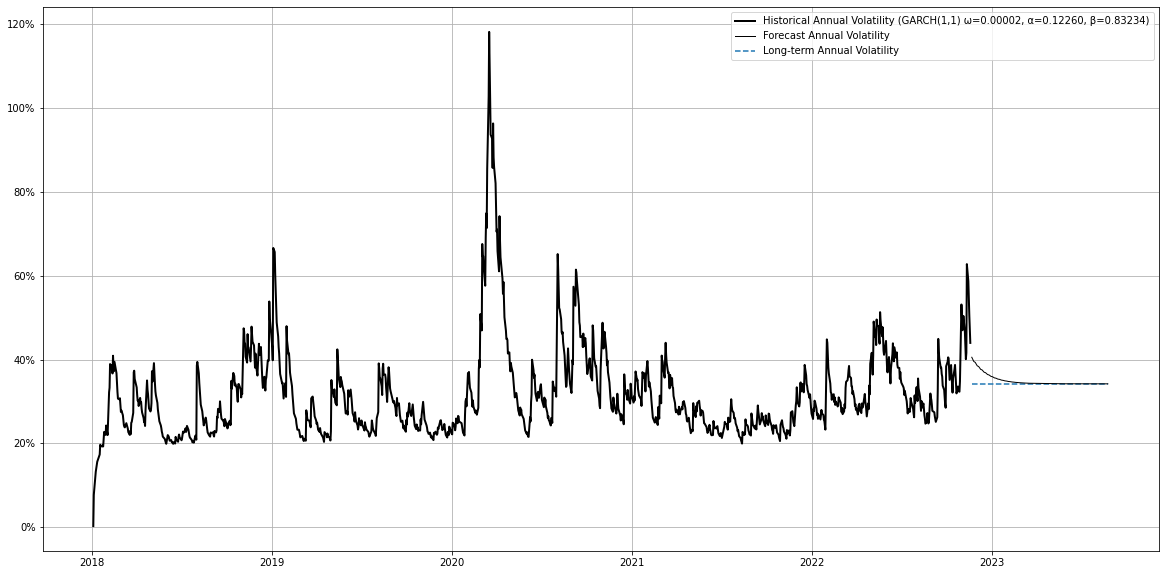

In [7]:
import matplotlib.pyplot as plt
x = vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities(),
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Apple stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility(), xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.grid(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

#### Optional: Visualizing the volatility term structure of Apple stock for 5 years into the future
A very important notion in pricing options is the _volatility term structure_. It defines the relationship between
the maturity of options and their volatilities. In other words it defines what the average volatility for a given maturity is forecast to be. Given the mean reverting nature of volatility, volatility for the longer terms trends towards the mean volatility of a given asset.

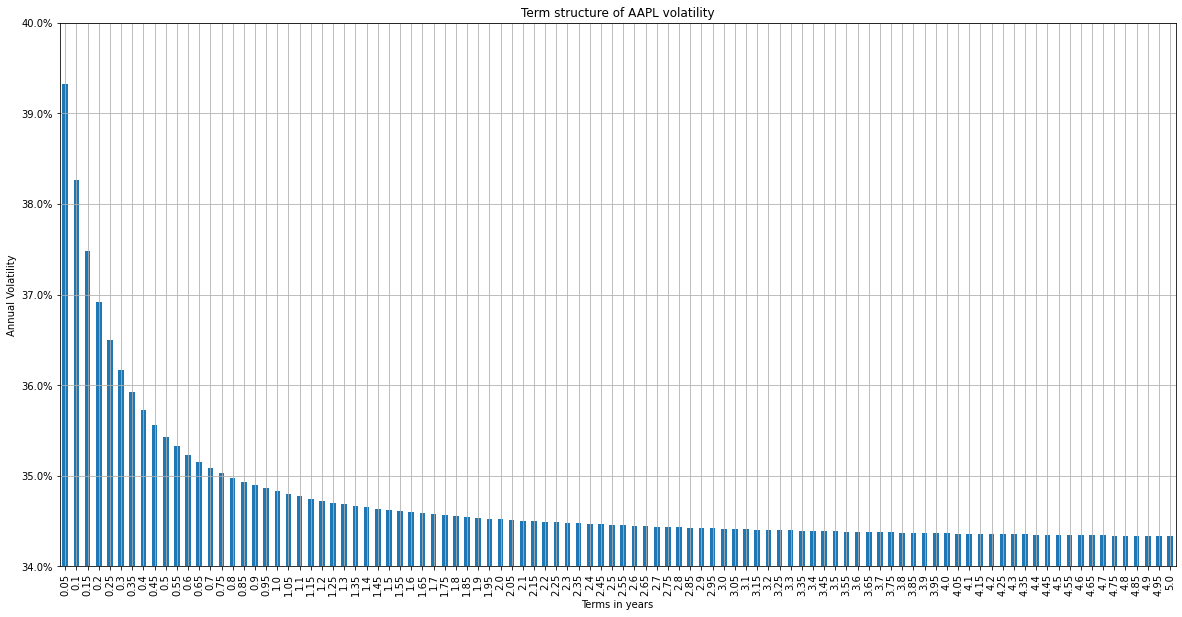

In [8]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of ' + TICKER + ' volatility')
ax.set_ylim(bottom=floor(series.min()), top=ceil(series.max()))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including on stock that pays dividends. With enough customizations it can also be used to price American call options (even those paying dividends). This is based on the fact that it is never optimal to exercise an American call option prematurely except on days immediately preceeding ex-dividend days for the stock. The `pricing.options.BlackScholesMertonPricer` class from this repository implements this customization to price American call options.

Let's put it to use to price an AAPL call option with a strike of $180. Apple pays dividends. It's essential to take into account dividends that get payed during the lifetime of an option to get an accurate price.

In [9]:
strike = 180.

# Yahoo-dividends returns the most recent ex-dividend date in the first row
last_divs = web.DataReader(TICKER, 'yahoo-dividends', today.year).value

# An approximate rule for Apple's ex-dividend dates -- ex-dividend date is on the first Friday
# of the last month of a season.
idx = (pd.date_range(last_divs.index[0].date(), freq='WOM-1FRI', periods=30)[::3])
divs = pd.Series([last_divs[0]] * len(idx), index=idx, name=TICKER + ' Dividends')

cur_price = asset_prices[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2023-01-20, price: 1.82, σ: 0.3721, Δ: 0.158, Γ: 0.010, ν: 15.191


Sometimes you might want to price using _an implied volatility_ for a given expiry date. You get the implied volatilty from the option prices of market makers. The `pricing.options.BlackScholesMertonPricer` class supports this. Just enter the implied volatility value instead of passing it a volatility_tracker object:

In [10]:
# Pricing with an implied volatility of 27.53%
pricer = options.BlackScholesMertonPricer(maturity_date, .2753, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2023-01-20, price: 0.61, σ: 0.2753, Δ: 0.081, Γ: 0.009, ν: 9.405


As you can see, a lower volatility resulted in a decrease of $1.21 in the price.

Let's now price an AAPL call option with a longer maturity. This is a little more complex as there are ex-dividend dates during the option's lifetime.

In [11]:
maturity_date = date(2023, month=3, day=17)
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

AAPL AMERICAN call option with strike 180.0 and maturity 2023-03-17, price: 4.16, σ: 0.3603, Δ: 0.248, Γ: 0.010, ν: 27.316


If you wonder where the volatility forecast of 36.03% came from, it came from the GARCH(1, 1) `vol_tracker` object I passed to the BlackScholesMertonPricer. You can easily see this:

In [12]:
vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))

0.36032712292530156

## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on stock that pays dividends.

Let's put it to use to price an AAPL call and put option with a strike of $180 and compare resulting prices for call options.

In [13]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))

AAPL AMERICAN call option with strike 180.0 and maturity 2023-03-17, price: 4.14, σ: 0.3603, Δ: 0.246, Γ: 0.010, ν: 24.443
Price difference between Black-Scholes-Merton and Binomial Treee pricers: 0.021412


Let's now price an AAPL put option with the same maturity. You cannot price put options with a BlackScholesMerton pricer, with a BinomialTreePricer you can.

In [14]:
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

AAPL AMERICAN put option with strike 180.0 and maturity 2023-03-17, price: 31.19, σ: 0.3603, Δ: -0.779, Γ: 0.011, ν: 23.068


If you wish to price with a given implied volatility, just pass it to the pricer as the second parameter:

In [15]:
impl_vol = .3054
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

AAPL AMERICAN call option with strike 180.0 and maturity 2023-03-17, price: 2.78, σ: 0.3054, Δ: 0.201, Γ: 0.011, ν: 25.032
AAPL AMERICAN put option with strike 180.0 and maturity 2023-03-17, price: 29.95, σ: 0.3054, Δ: -0.835, Γ: 0.012, ν: 21.825
